In [1]:
import re
import os,stat
import pandas as pd
import email
from bs4 import BeautifulSoup

from nltk.tokenize import  word_tokenize
from nltk.corpus import stopwords
#词形还原工具
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

import warnings

 
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import lda
lda.lda
import matplotlib.pyplot as plt

### functions

In [2]:
def read_file(filename):
    '''
    从eml文件读出邮件内容
    :param: filename: email文件路径名
    :return: 邮件主题和邮件内容字符串, 可能带 html 格式
    '''
    with open(filename, encoding='latin-1') as fp:
        msg = email.message_from_file(fp)
        payload = msg.get_payload()
        if type(payload) == type(list()):
            payload = payload[0]
        if type(payload) != type(''):
            payload = str(payload)
            
        sub = msg.get('subject')
        sub = str(sub)
        return sub ,payload

In [3]:
def clean_html(raw_html):
    '''
    清除邮件内容中的 html 标签
    :param raw_html: 带 html 标签的文本内容
    :return: 不带 html 标签的文本内容
    '''
    return BeautifulSoup(raw_html, 'html.parser').text

In [4]:
def cleansymbols(x):
    '''
    清除邮件内容中的超链接和各类符号
    :param x:传入的字符串
    :return: 清洗后的文本内容
    '''
    cleanx = re.sub('(http(s)?://)?[0-9A-Za-z]+\.[0-9A-Za-z]+[0-9A-Za-z/.-]+', '', x) # 去掉超链接
    cleanx = re.sub("(\[[0-9]\])|[\"/–,;\\:.©£•!\?\-\+~@#›￥%……&*\(\)\|“>”/\']|(\\n)", " ", cleanx) # 去掉各种符号
    return cleanx

### Main

In [5]:
pathname = 'TR'
# 下面遍历所有邮件文件，并把邮件中的主题、正文、发送人提取出来，保存到pandas的dataframe里。
count=0
filelist=os.listdir(pathname)
filelist.sort(key= lambda x:int(x[6:-4]))
IDs=[]
Bodys=[]
print("读取邮件...")
for file in filelist:
    fpath = os.path.join(pathname, file)
    info = os.stat(fpath)
    if stat.S_ISREG(info.st_mode) and file.endswith('.eml'):
        '''
        1. 从邮件文件出读出所有文本
        2. 对邮件正文进行清理并保存
        '''
        sub,text=read_file(fpath)
        text = clean_html(text)
        IDs.append(str(count))
        Bodys.append(str(sub+text))
            
        count+=1
rawdata=pd.DataFrame({'ID':IDs,'Body':Bodys})
rawtext = rawdata['Body'].tolist()

读取邮件...


In [6]:
rawdata.head()

,ID,Body
0,0,One of a kind Money maker! Try it for free!Con...
1,1,link to my webcam you wanted Wanna see sexuall...
2,2,Re: How to manage multiple Internet connection...
3,3,[SPAM] Give her 3 hour rodeoEnhance your desi...
4,4,Best Price on the netf5f8m1 (suddenlysusan@Sto...


In [7]:
# 清洗文本
print("清洗数据...")
sentences = []
for t in rawtext:
    sentences.append(t)
    
for i,sen in enumerate(sentences):
    sentences[i] = cleansymbols(sen)

清洗数据...


In [8]:
# 分词，去除停用词、短词和含有数字的词
print("分词...")
doc_tokens = [word_tokenize(sen) for sen in sentences]

分词...


In [9]:
print("文本预处理...")
stops = np.array(stopwords.words('english'))
stops=np.union1d(stops,['org', 'com', 'net','www','ur','http','E','D','Re','The','just','one'])
doc_tokens_removed = []
for one_doc_tokens in doc_tokens:
    new_token = []
    for token in one_doc_tokens:
        lt = token.lower()
        if not(lt in stops  or len(lt)<3) and ('0' not in str(lt)) and ('1' not in str(lt)) and ('2' not in str(lt)) and ('3' not in str(lt)) and ('4' not in str(lt)) and ('5' not in str(lt)) and ('6' not in str(lt)) and ('7' not in str(lt)) and ('8' not in str(lt)) and ('9' not in str(lt)) and ('__' not in str(lt)):
            lemma_token = lemma.lemmatize(lt) # 词干化处理
            if (len(lemma_token)>=3):
                new_token.append(lemma_token)
    doc_tokens_removed.append(new_token)

文本预处理...


In [10]:
#    形成词袋模型的向量
print("形成词袋模型向量...")
raw_X = [str(doc) for doc in doc_tokens_removed]
vect = CountVectorizer()

形成词袋模型向量...


In [11]:
print("话题模型训练...")
X=vect.fit_transform(raw_X)
vocab=vect.get_feature_names()
model =lda.LDA(n_topics=10, n_iter=50, random_state=3)
model.fit(X)

话题模型训练...


INFO:lda:n_documents: 2500
INFO:lda:vocab_size: 35669
INFO:lda:n_words: 370612
INFO:lda:n_topics: 10
INFO:lda:n_iter: 50
INFO:lda:<0> log likelihood: -4414228
INFO:lda:<10> log likelihood: -3511037
INFO:lda:<20> log likelihood: -3379504
INFO:lda:<30> log likelihood: -3337665
INFO:lda:<40> log likelihood: -3315413
INFO:lda:<49> log likelihood: -3300383


10个话题各自指向了某些话题领域，从他们的主要词项分布可以做如下分析：<br>
0、	关于科技网络计算机的发展。<br>
1、	主要谈及网络安全方面的的术语。关于美国的发展，环境保护。<br>
2、	有关教育，社会。<br>
3、	关于debian这款软件的退订，用户的请求等问题。<br>
4、	有关军事。<br>
5、	这个话题是关于邮件解决退订问题的。<br>
6、	这个话题大概是关于文件列表，电脑窗口的bug处理。<br>
7、	关于个人家庭生活。<br>
8、	是关于消息列表内容，传输，前端的设计，包括字体、字号、颜色、边框等。<br>
9、	关于邮件，提到人们使用时间，获取报告。<br>

In [12]:
#打印各个话题中的词分布
topic_word = model.topic_word_  
    
n = 10  
for i, topic_dist in enumerate(topic_word):  
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]  
    print('*Topic {}\n- {}'.format(i, ' '.join(topic_words)))

*Topic 0
- free company service product click new information offer please year
*Topic 1
- x94 x80â united change dsa lincoln coin state style year
*Topic 2
- group also state first world government said alb year people
*Topic 3
- unsubscribe debian user wrote request email subject contact archive trouble
*Topic 4
- united well non botanical following held body two various natural
*Topic 5
- file user kde linux list use window new version change
*Topic 6
- razor new film quicktime long fork result list class admin
*Topic 7
- name type home control merciadri man work thing good men
*Topic 8
- font text size color content checksum price family type plain
*Topic 9
- email list mail get message time make people would address


topic统计绘图...


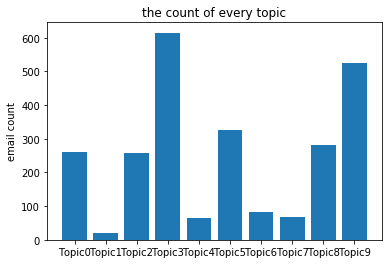

In [13]:
#绘制topic统计条形图
print("topic统计绘图...")
doc_topic = model.doc_topic_  
topic_count=[0 for i in range(10)]
for n in range(len(doc_topic)):  
    max_idx = doc_topic[n].argmax()
    topic_count[max_idx]+=1
#绘制条形图
plt.bar([i for i in range(10)],topic_count)
plt.xticks(np.arange(10), ('Topic0','Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6','Topic7','Topic8','Topic9'))
plt.ylabel('email count')
plt.title('the count of every topic')
plt.show()